<a href="https://colab.research.google.com/github/anshulsawant/Void-Seg/blob/main/BCE%20SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ssh-keyscan -t ed25519 github.com > ~/.ssh/known_hosts
!rm -rf /content/Void-Seg/
!git clone https://github.com/anshulsawant/Void-Seg.git
import tensorflow as tf

from google.colab import drive

import cv2

from glob import glob
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn import metrics as skm
import random

from tensorflow.python.ops import math_ops

SIZE = 1024

import sys
if not '/content/Void-Seg/src' in sys.path:
  sys.path.append('/content/Void-Seg/src')
import importlib
importlib.invalidate_caches()
import images
import datasets
import utils
import metrics as M
importlib.reload(images)
importlib.reload(datasets)
importlib.reload(utils)
importlib.reload(M)

/bin/bash: /root/.ssh/known_hosts: No such file or directory
Cloning into 'Void-Seg'...
remote: Enumerating objects: 5066, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 5066 (delta 147), reused 204 (delta 132), pack-reused 4834
Receiving objects: 100% (5066/5066), 282.97 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (2103/2103), done.
Updating files: 100% (5123/5123), done.


<module 'metrics' from '/content/Void-Seg/src/metrics.py'>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading images from /content/Void-Segmentation/dataset/train.
/content/Void-Segmentation
864
571
/content/Void-Segmentation/dataset/train/images/100kX_300kV_0636_4_2_flip_rot270.png
(512, 512, 1)
(512, 512, 1)


<Figure size 720x1440 with 0 Axes>

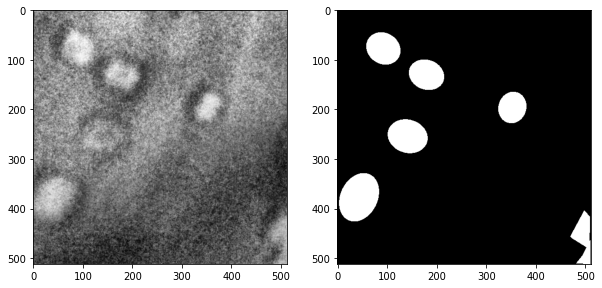

In [ ]:
u, v, _, _ = images.load_image_paths()
print(images.ROOT)
print(len(u))
## Can you spot the problem in the masks below?
i = random.randint(0, len(u))
print(i)
print(u[i])
x = images.load_image(u[i])
y = images.load_mask(v[i])
print(x.shape)
print(y.shape)

raw_image = cv2.imread(u[i])
raw_mask = cv2.imread(v[i], flags=cv2.IMREAD_GRAYSCALE)
plt.rcParams["figure.figsize"] = (10,20)
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x[:,:,0], cmap = 'gray') 
axarr[1].imshow(y[:,:,0], cmap = 'gray')
plt.show()

**Image Augmentation Methods**

In [3]:
### WARNING: Do not edit. Freeze this model. This works!
def get_model():
    inputs = keras.Input((SIZE//2, SIZE//2))
    filters = [4,16,32,64]
    x0 = inputs
    x0 = layers.Reshape((SIZE//2, SIZE//2,1))(x0)
    ## x0 = layers.Dropout(0.1) (x0)

    def down_block(filters, t, dropout = 0.2):
      t1 = layers.Conv2D(filters, 5, padding="same", activation="relu") (t)
      t2 = layers.Conv2D(filters, 5, padding="same", activation="relu") (layers.concatenate([t, t1]))
      t3 = layers.MaxPooling2D(padding="valid") (layers.concatenate([t, t1, t2]))
      ## t3 = layers.Dropout(dropout)(t3)
      return t1, t2, t3

    x1, x2, x3 = down_block(4, x0) 
    x4, x5, x6 = down_block(16, x3)
    x7, x8, x9 = down_block(32, x6)

    def up_block(filters, t, dropout = 0.2):
      t1 = layers.Conv2D(filters, 5, padding="same", activation="relu") (t)
      t2 = layers.Conv2D(filters, 5, padding="same", activation="relu") (layers.concatenate([t, t1]))
      t3 = layers.Conv2DTranspose(filters//2, 2, 2, padding="valid") (layers.concatenate([t, t1, t2]))      
      ## t3 = layers.Dropout(dropout)(t3)
      return (t1, t2, t3)    

    x10, x11, x12 = up_block(64, x9)
    x13, x14, x15 = up_block(32, layers.concatenate([x6, x7, x8, x12]))
    x16, x17, x18 = up_block(16, layers.concatenate([x3, x4, x5, x15]))

    x19 = layers.Conv2D(4, 3, activation="relu", padding="same") (layers.concatenate([x0, x1, x2, x18]))
    x20 = layers.Conv2D(2, 7, activation="softmax", padding="same") (layers.concatenate([x0, x1, x2, x19]))

    y = layers.Lambda(lambda x: x[:,:,:,1]) (x20)
    y = layers.Flatten() (y)
    outputs = y
    model = keras.Model(inputs, outputs)
    return model

    # Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 4)  104         ['reshape[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 512, 512, 5)  0           ['reshape[0][0]',                
                                                                  'conv2d[0][0]']             

In [4]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="rec")]

def schedule(epoch, lr):
  return lr*np.exp(-0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Segmentation/segmentation_bce_50", save_best_only=True),
    keras.callbacks.LearningRateScheduler(schedule)
]
# Train the model, doing validation at the end of each epoch.
epochs = 50
training_data, validation_data = datasets.create_dataset(batch=32)
keras.backend.clear_session()

restore = True
retrain = False
if restore:
  model = tf.keras.models.load_model('/content/drive/MyDrive/Segmentation/segmentation_bce_50')
  if retrain:
    keras.backend.set_value(model.optimizer.learning_rate, 0.0001)
    model.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks = callbacks)
else:
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=metrics)
  model.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks = callbacks)

Loading images from /content/Void-Seg/dataset/train.
Creating dataset with 864 images.
Using 691 images for training.


In [ ]:
ds = datasets.create_test_dataset()

eval = model.evaluate(x = ds, return_dict=True)
print(eval)

Loading images from /content/Void-Segmentation/dataset/test.
Loading 28 images for testing.
4/4 [==============================] - 13s 260ms/step - loss: 0.1083 - acc: 0.9564 - auc: 0.9859 - prec: 0.8695 - rec: 0.8685
{'loss': 0.10828348249197006, 'acc': 0.9563726782798767, 'auc': 0.9858506917953491, 'prec': 0.8694660663604736, 'rec': 0.8684918880462646}


Loading images from /content/Void-Seg/dataset/test.
Loading 28 images for testing.
1/1 [==============================] - 0s 20ms/step


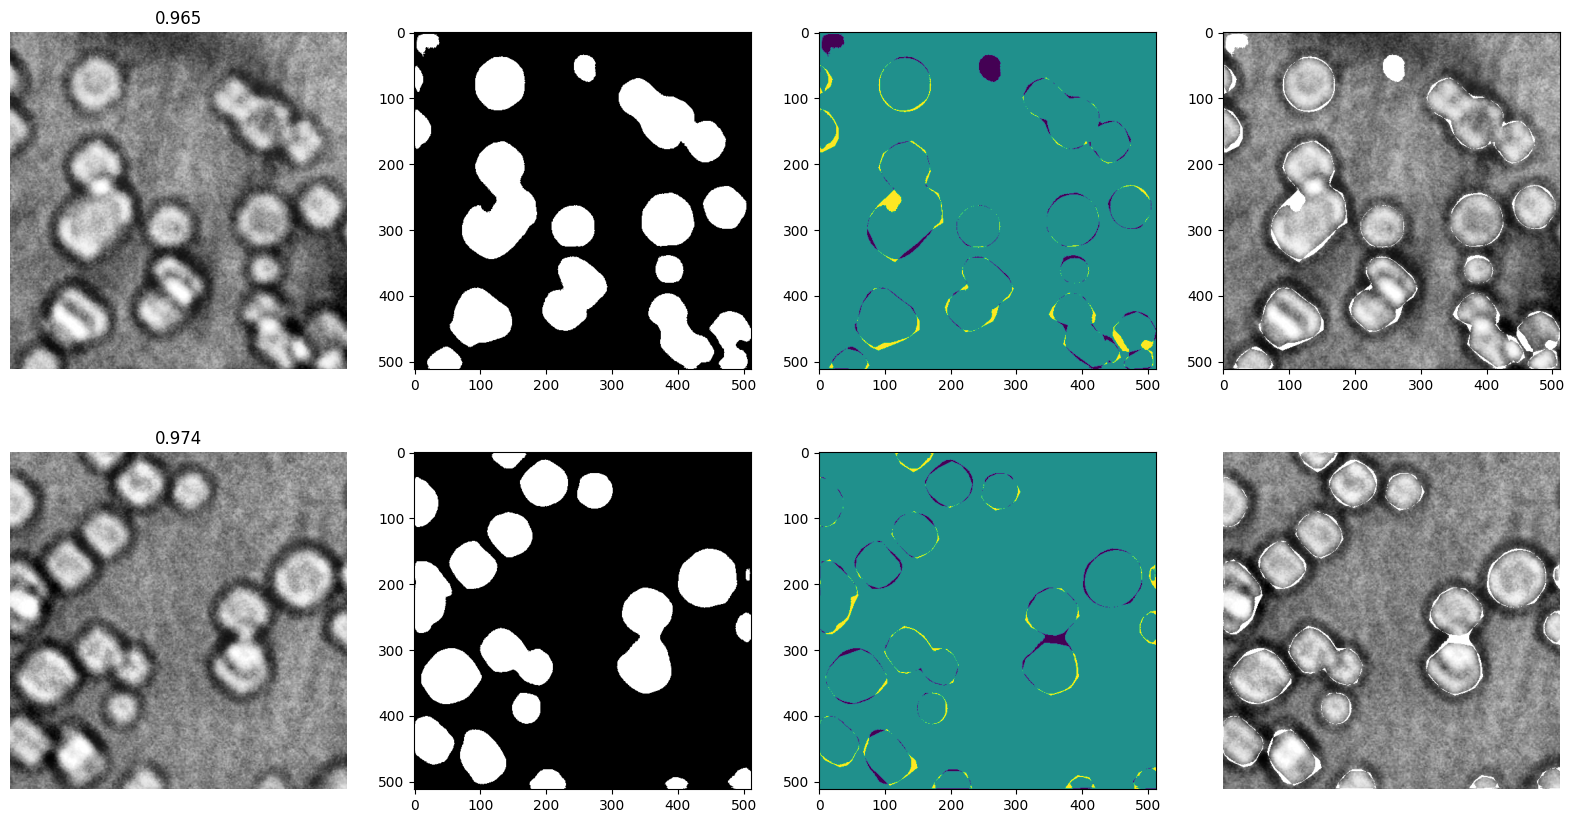

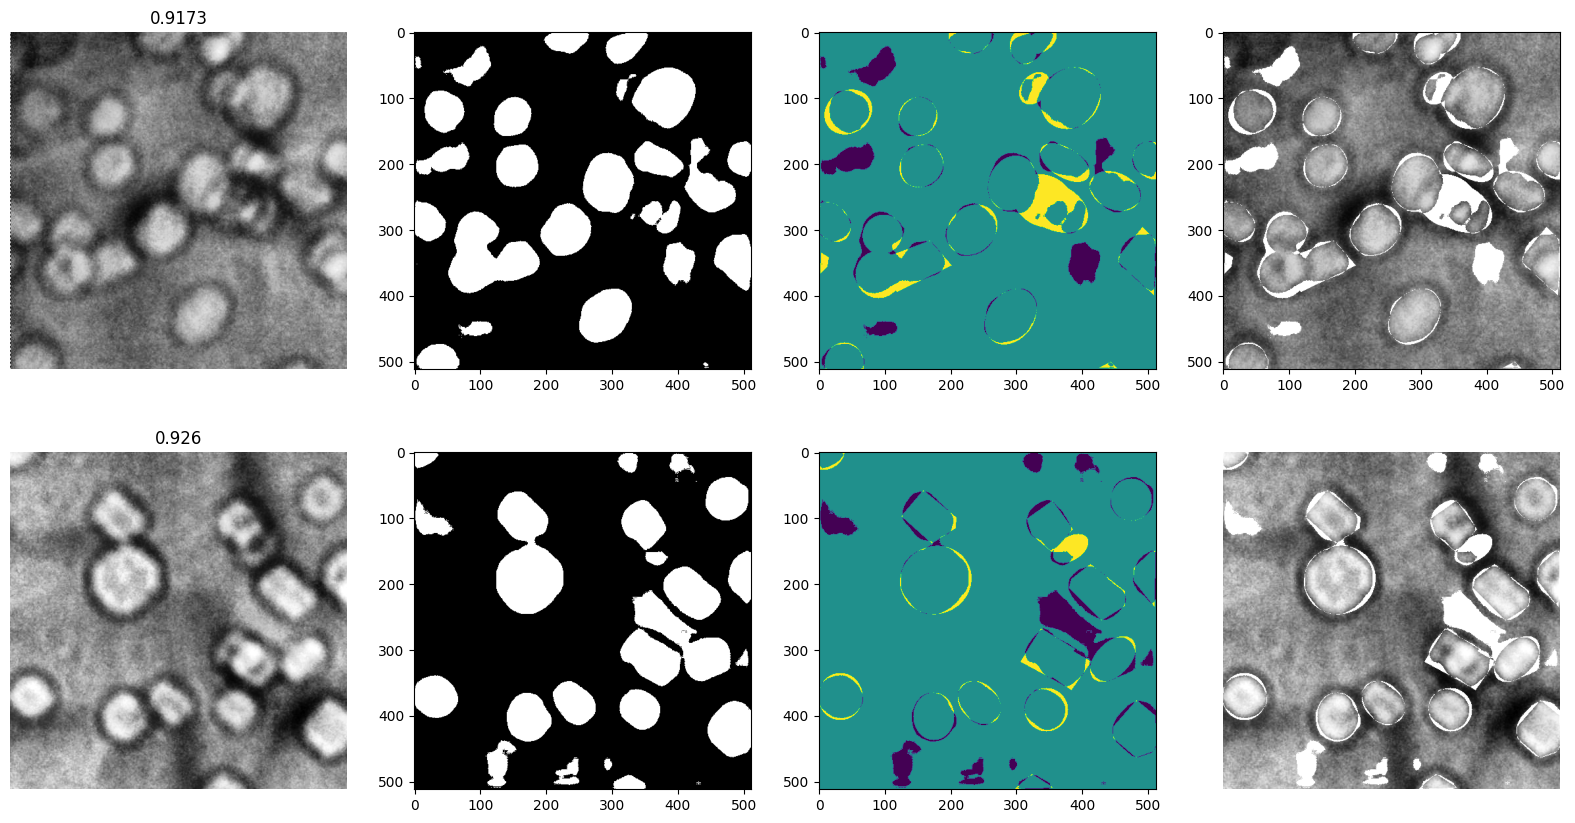

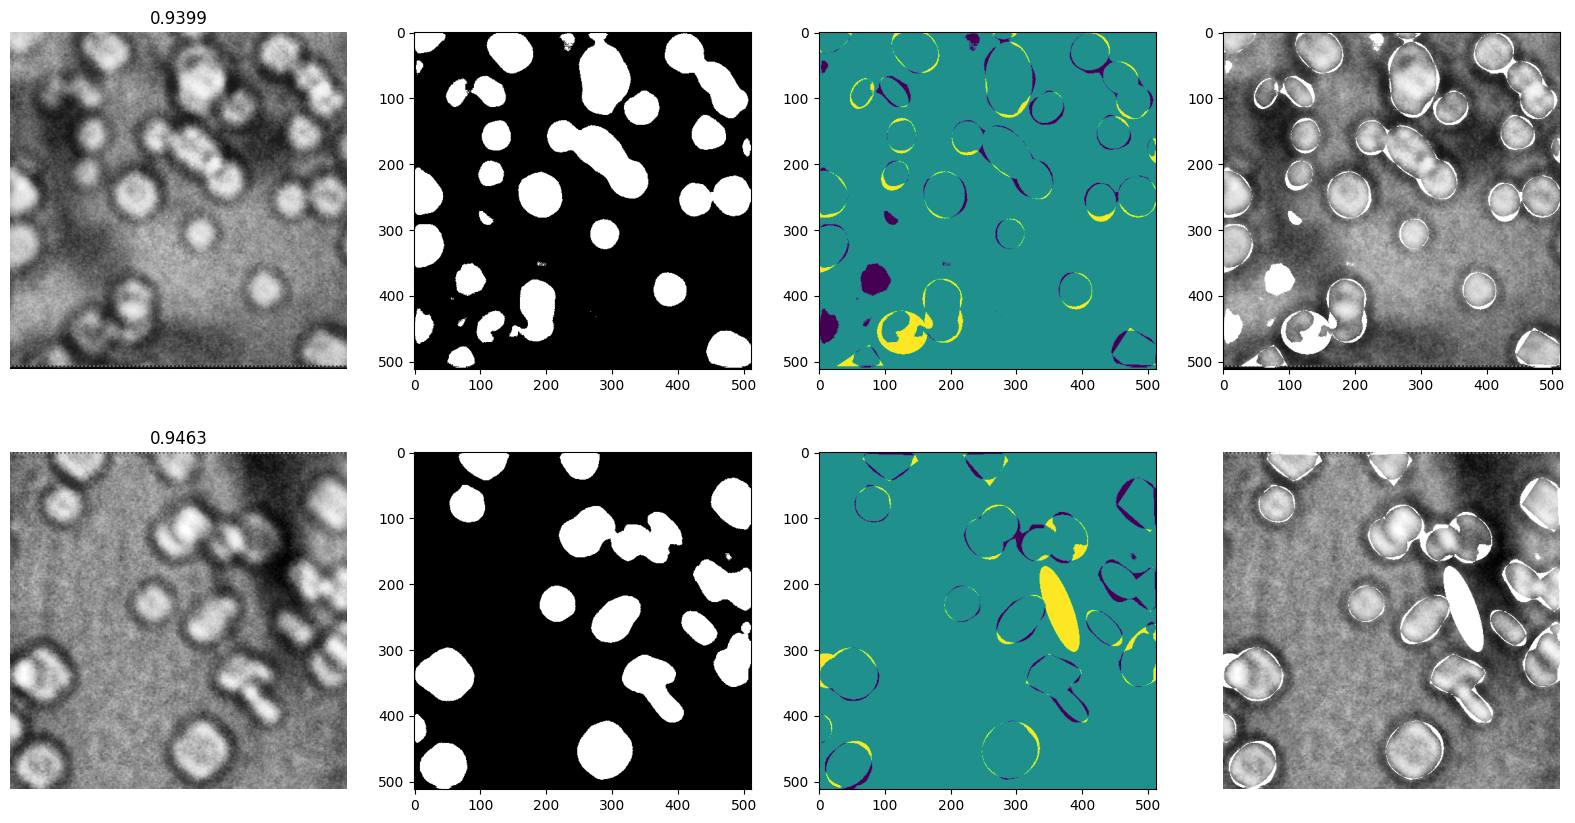

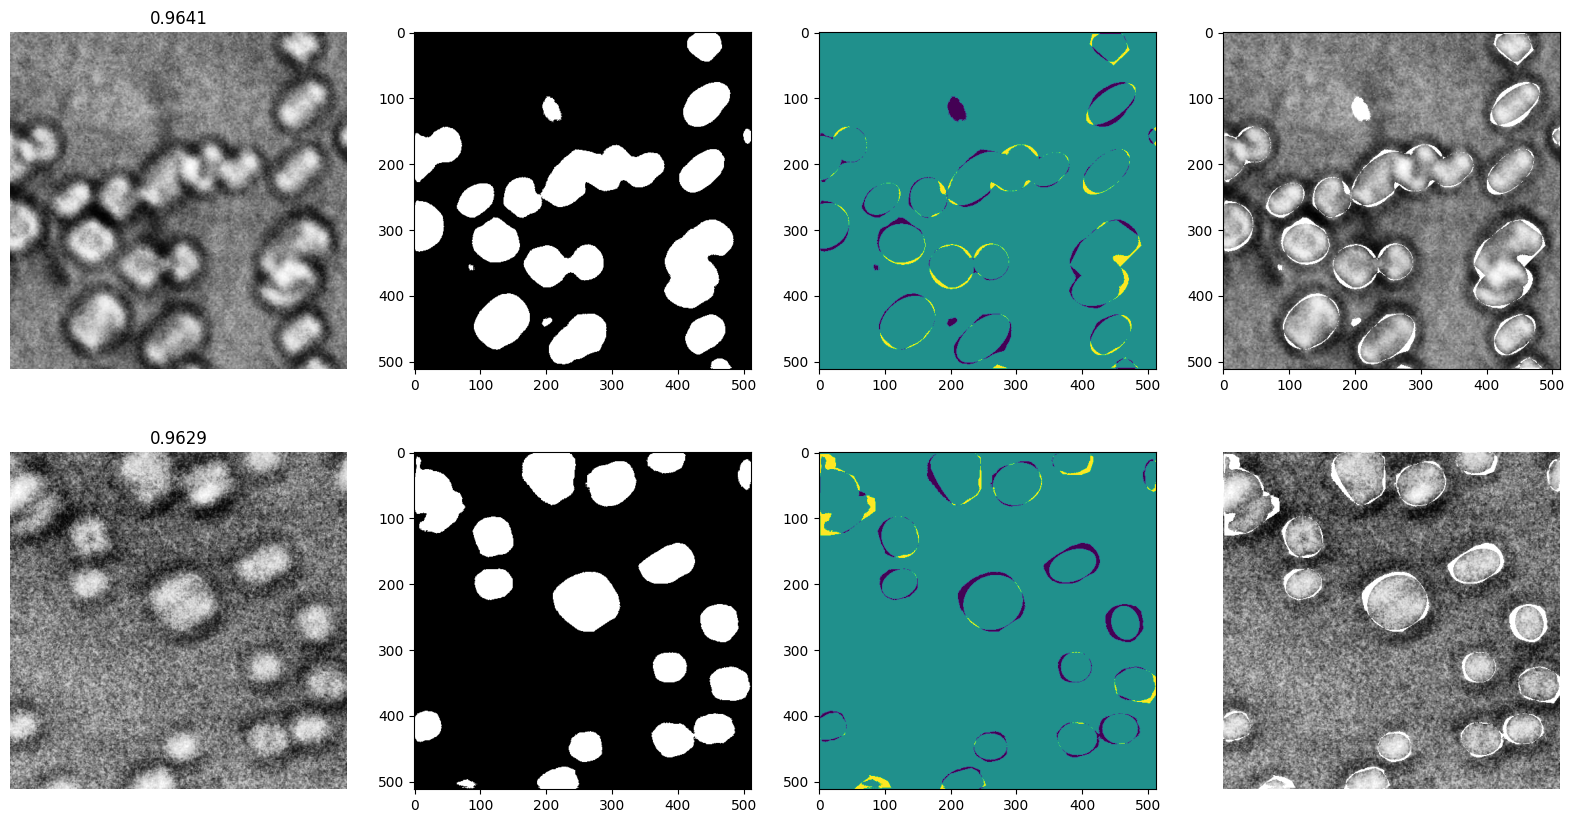

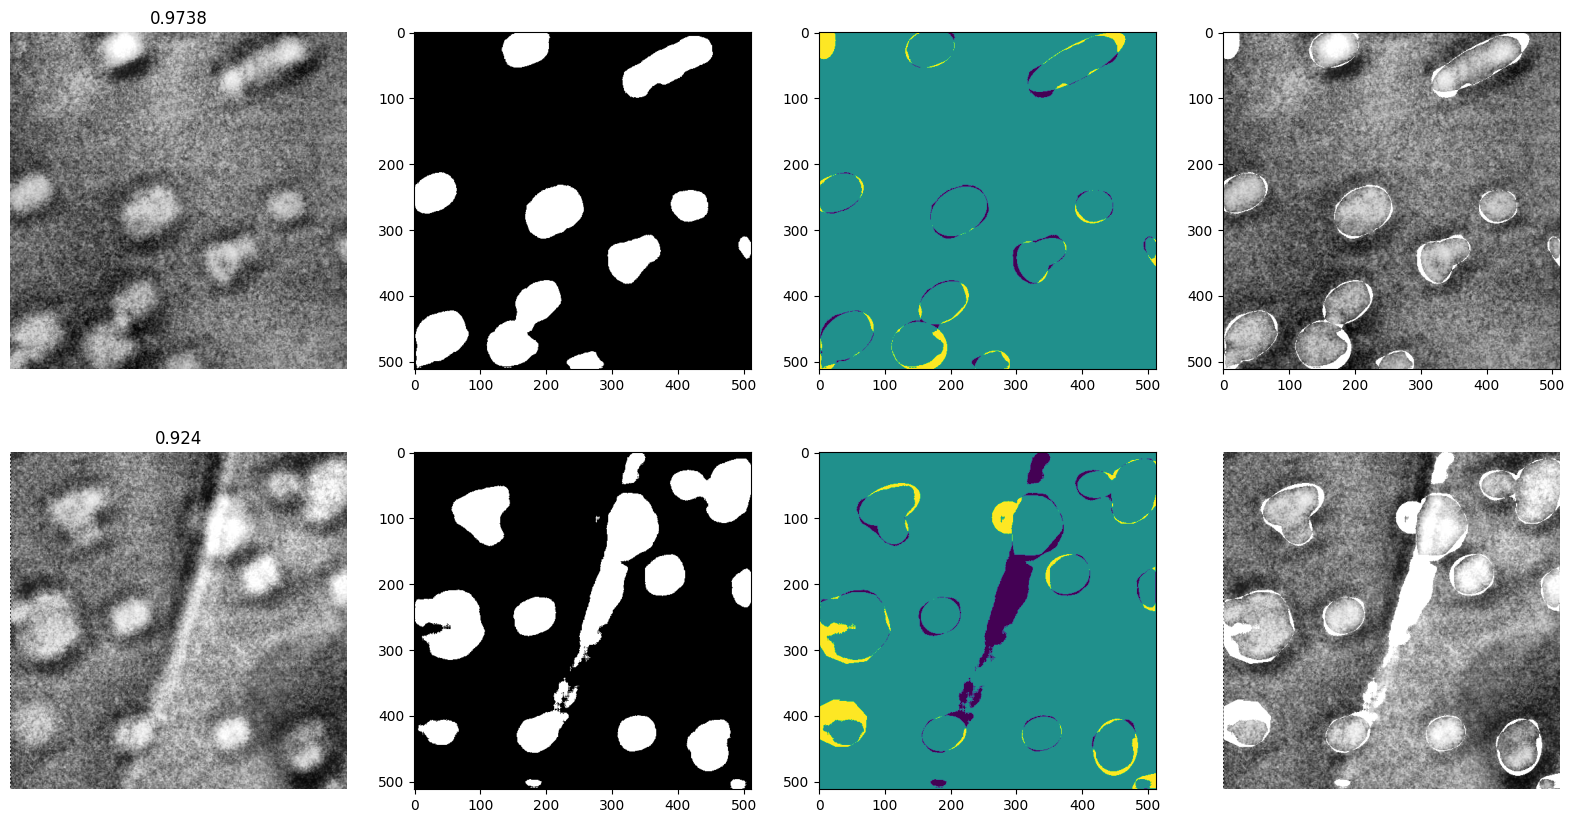

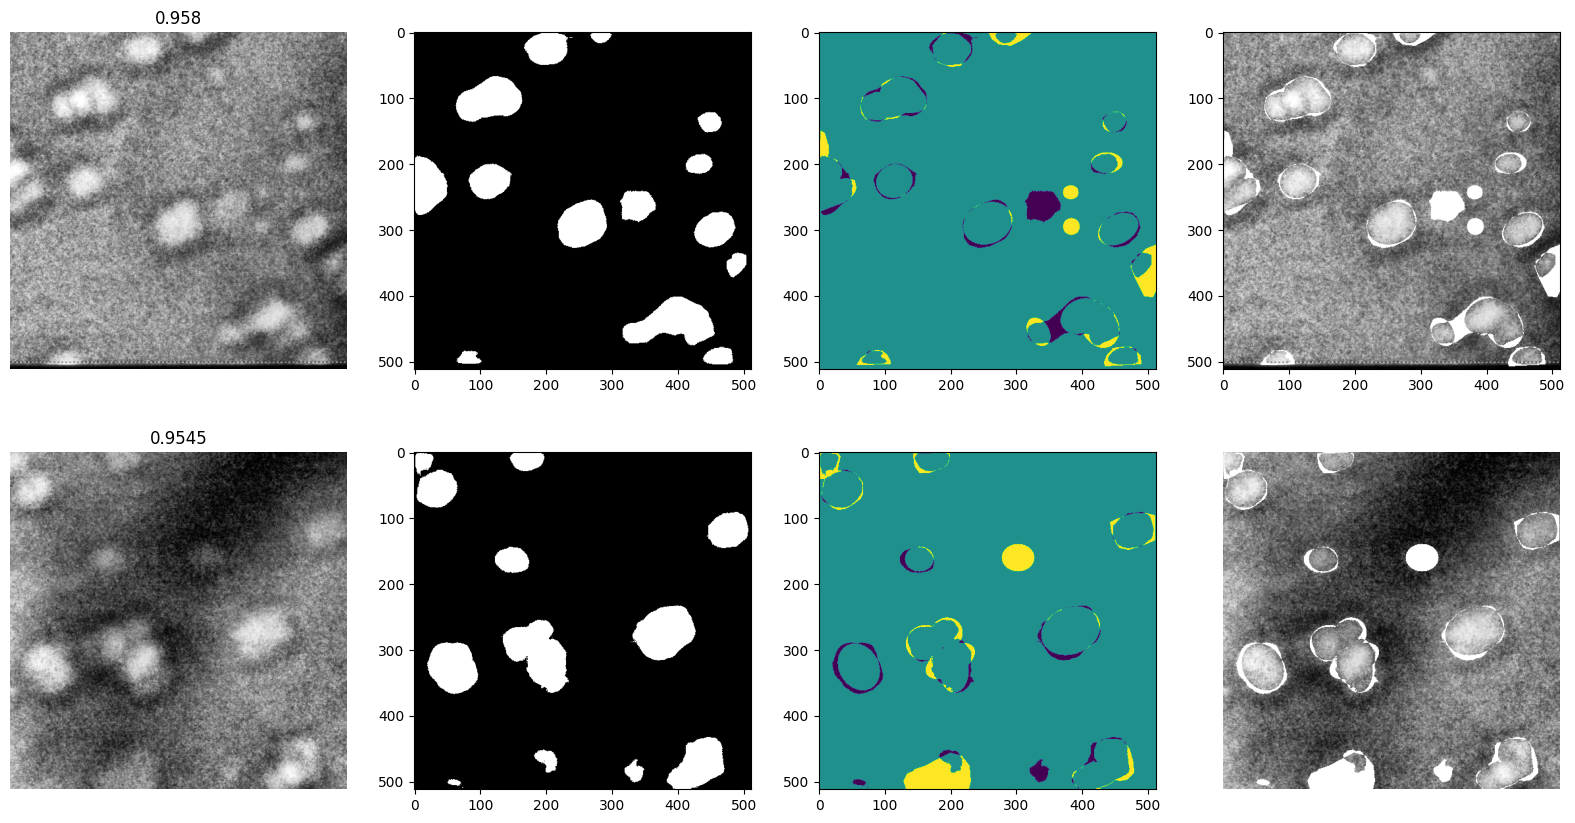

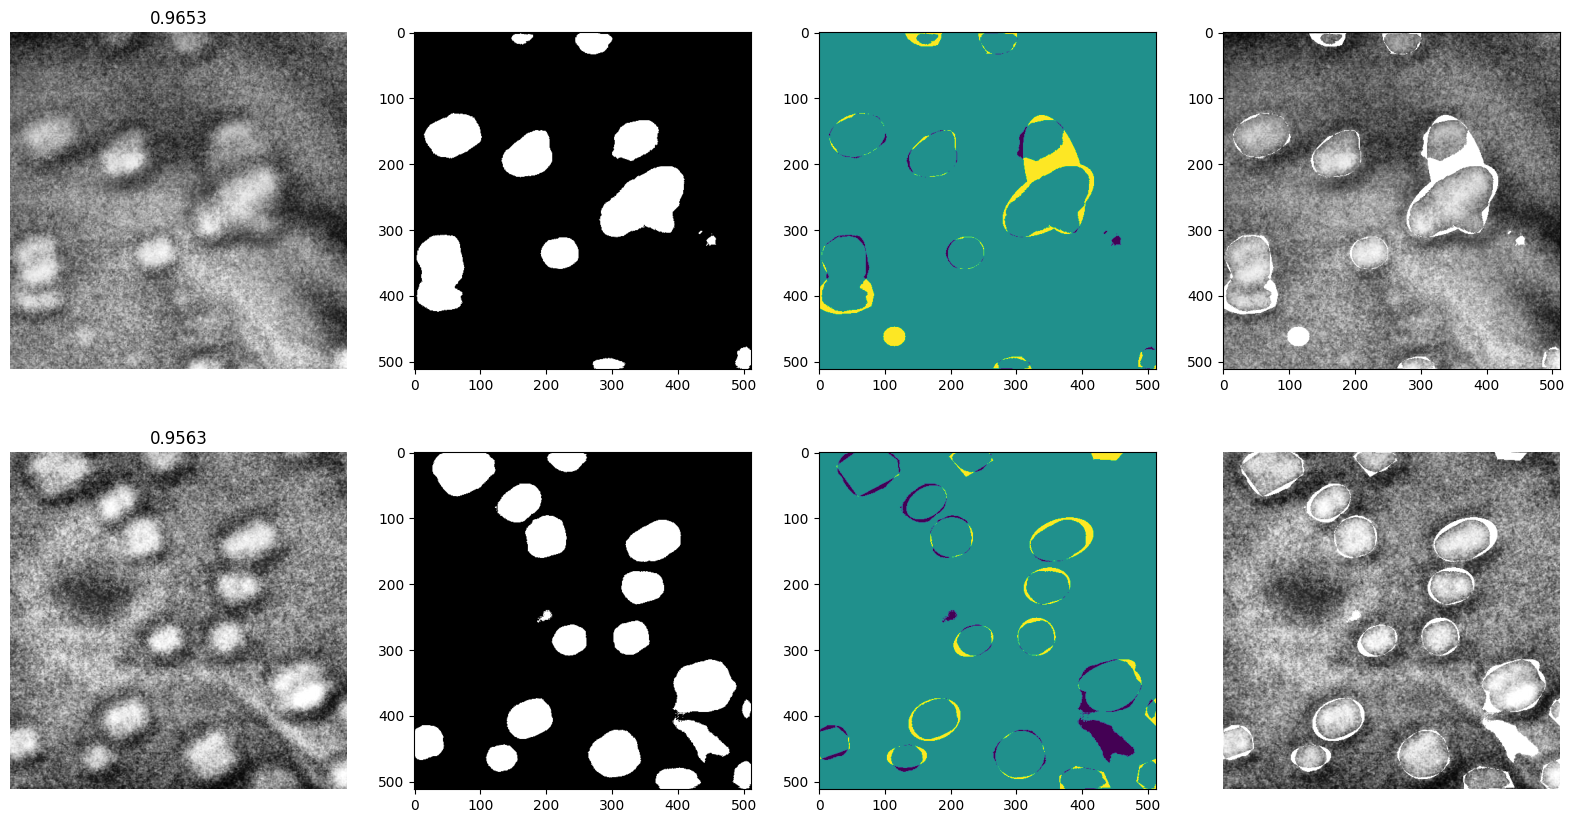

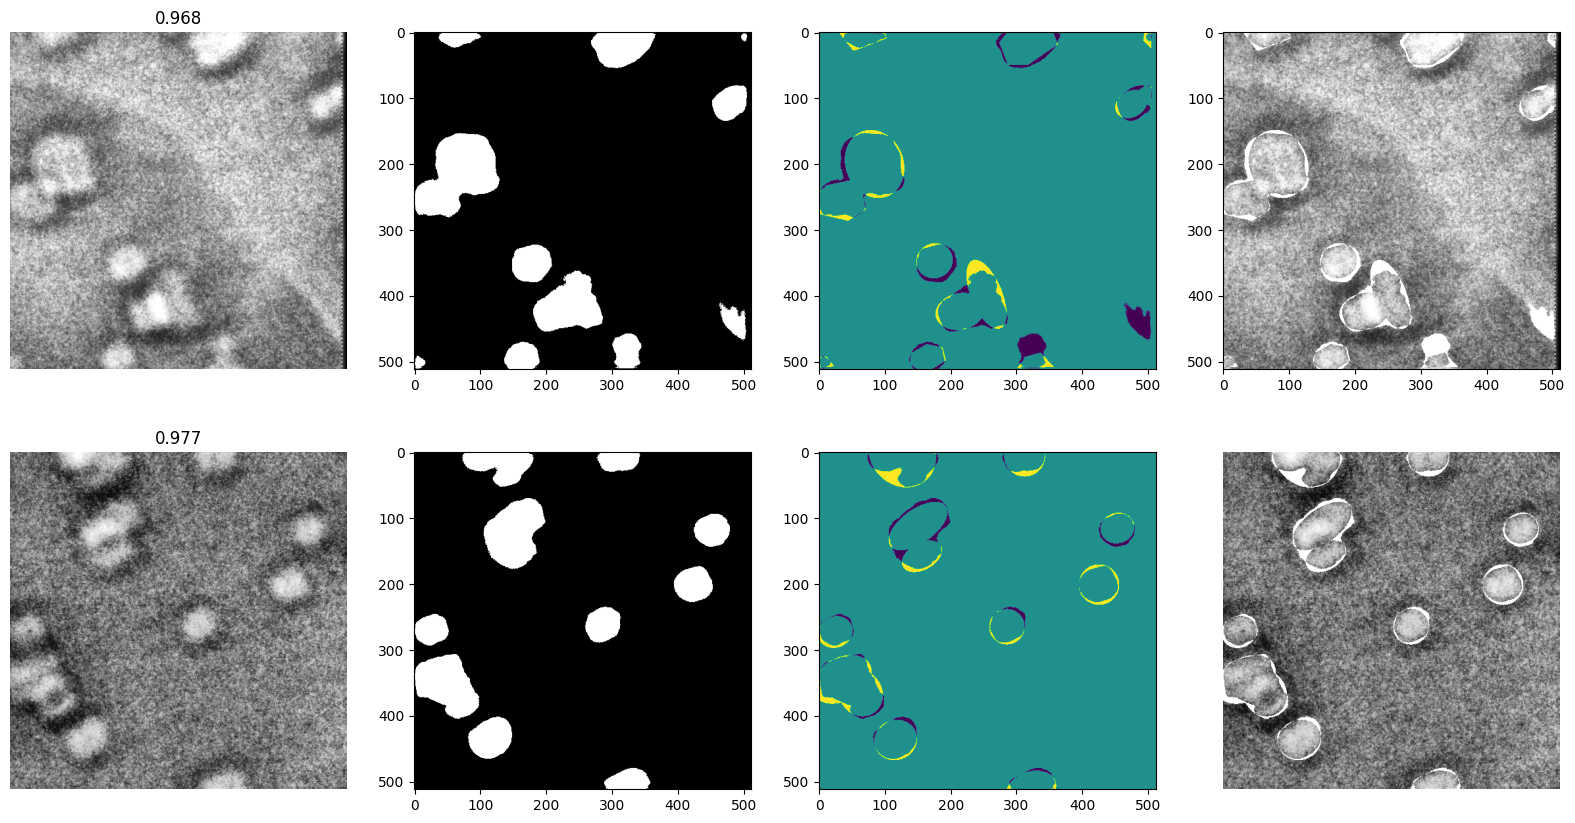

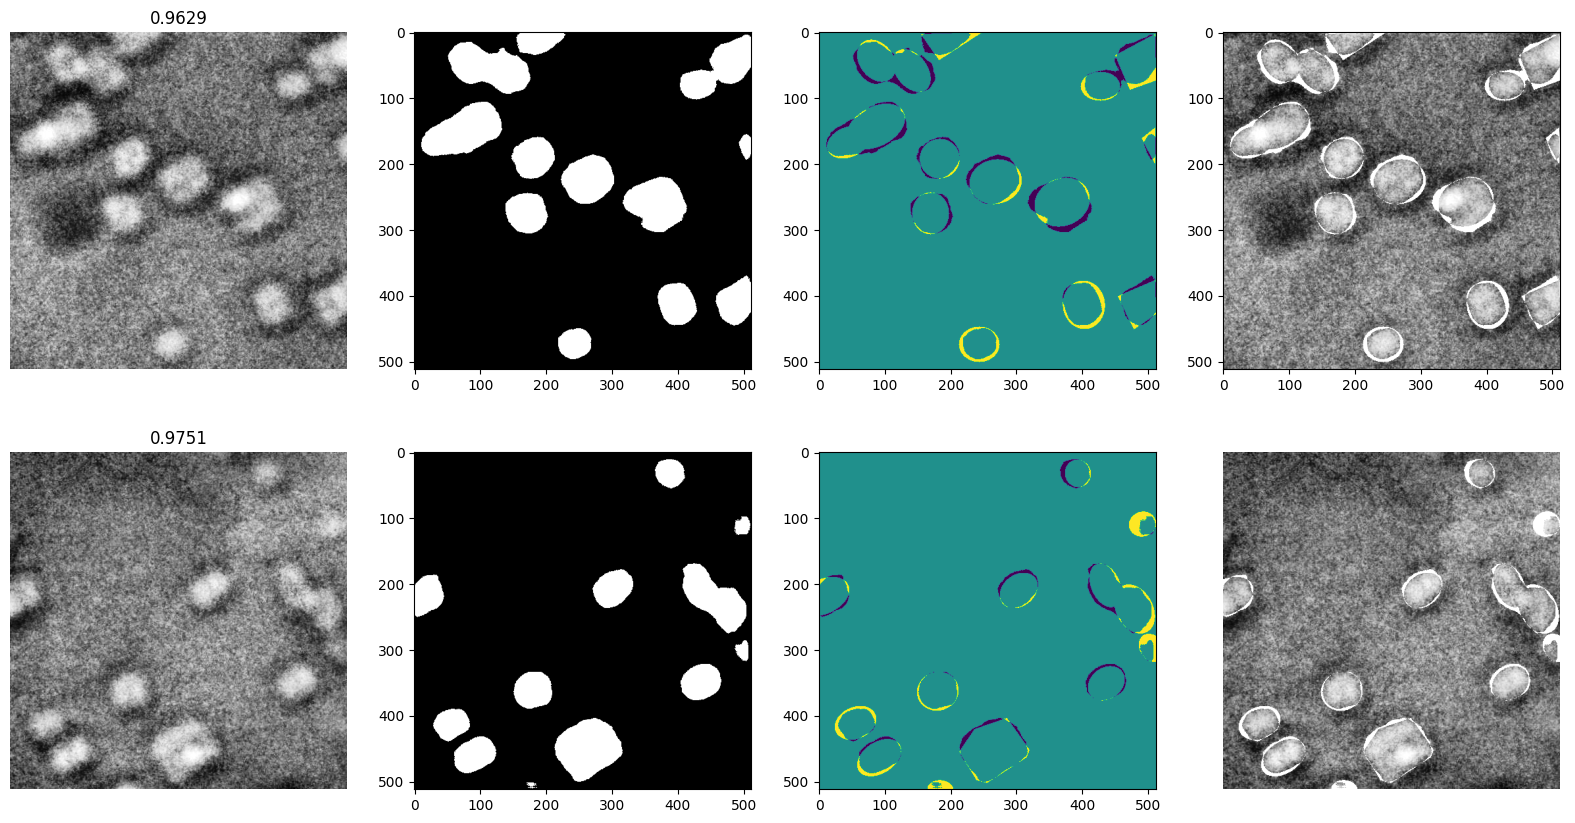

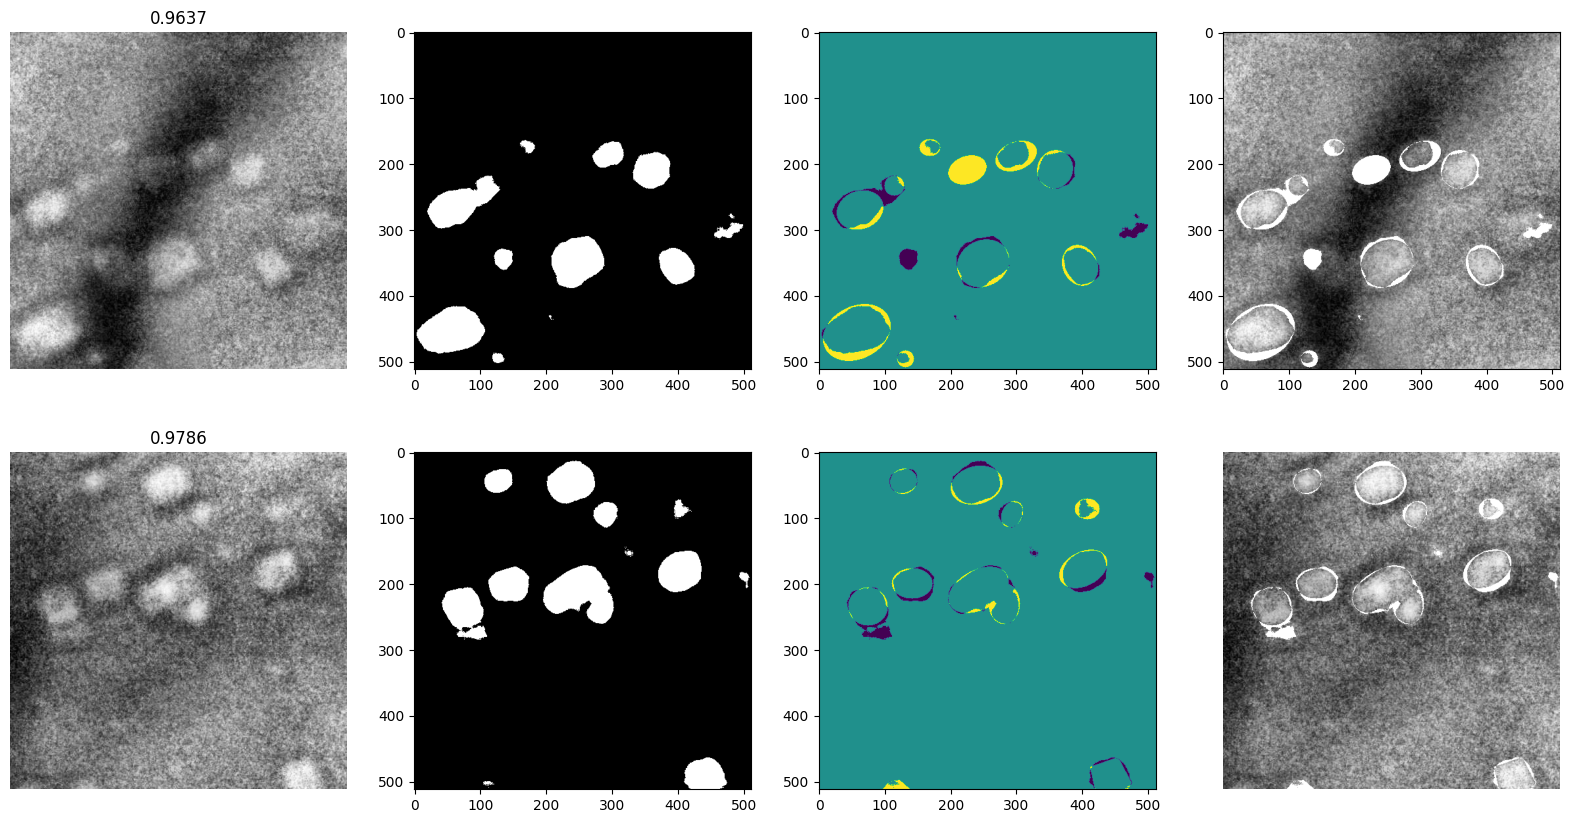

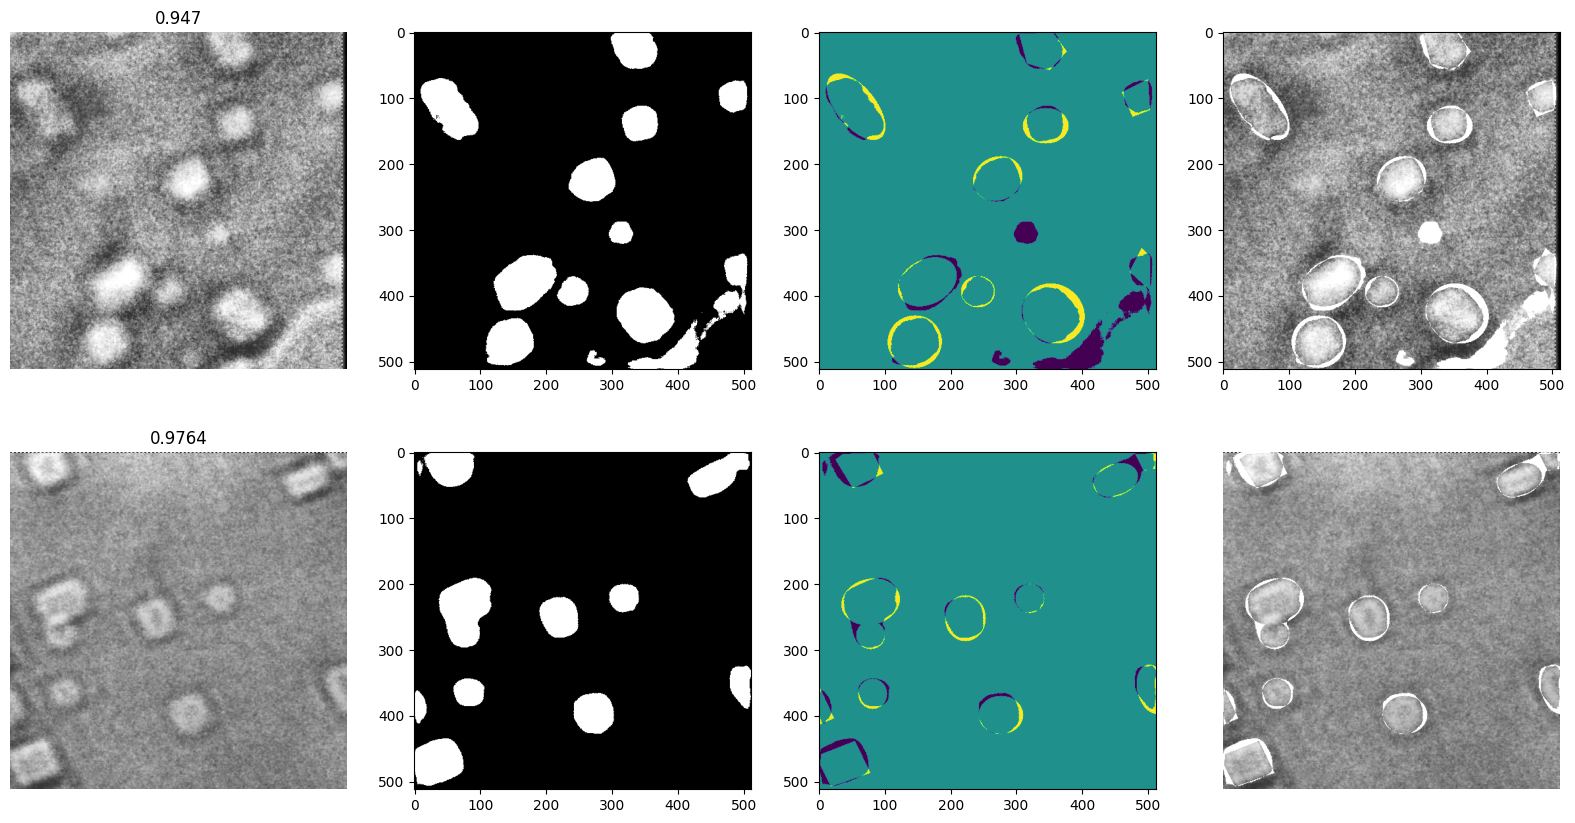

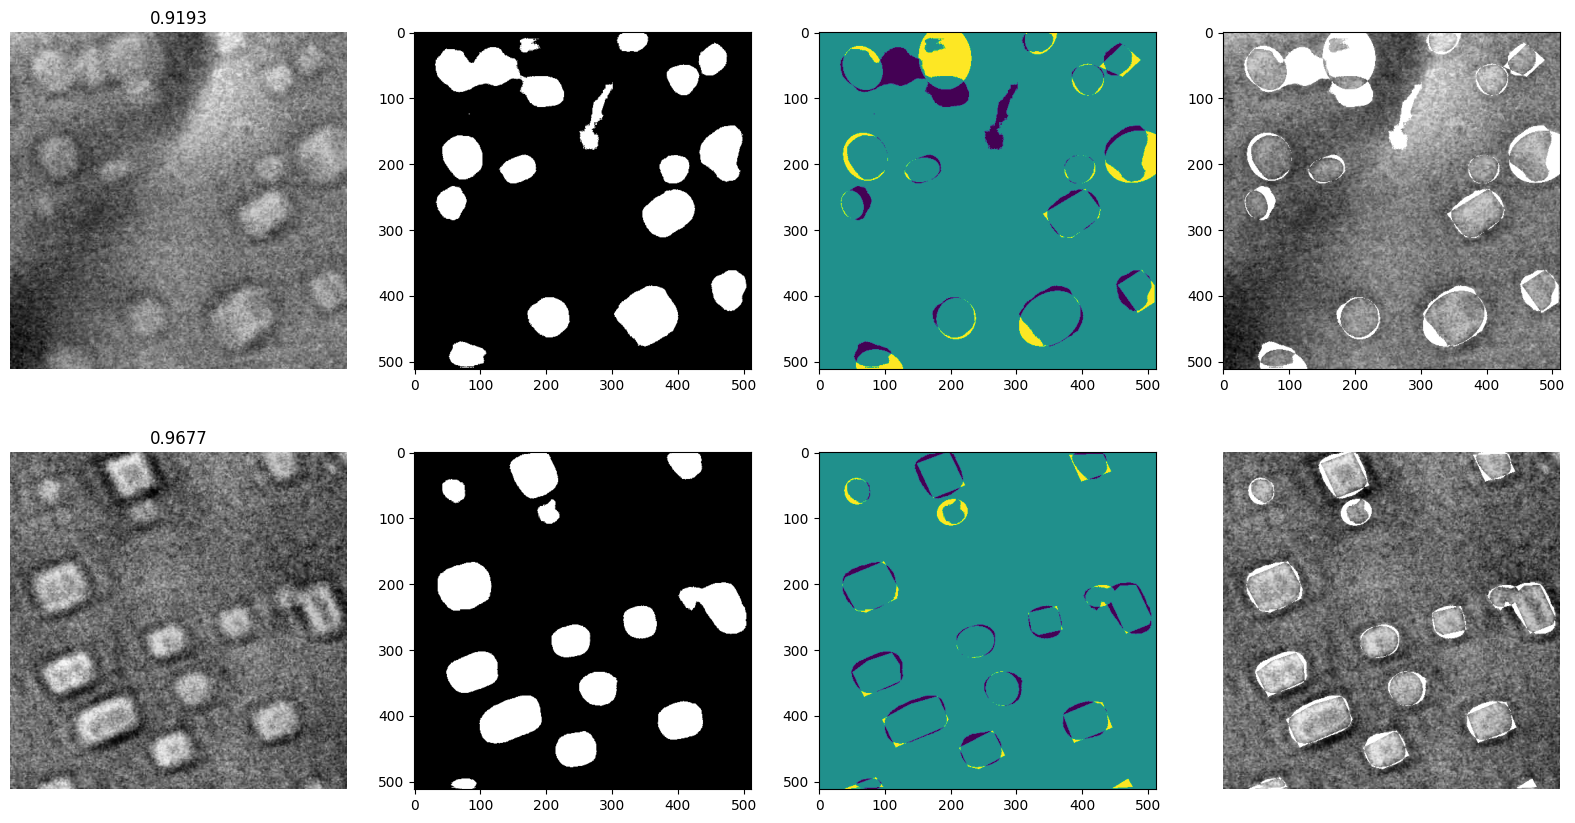

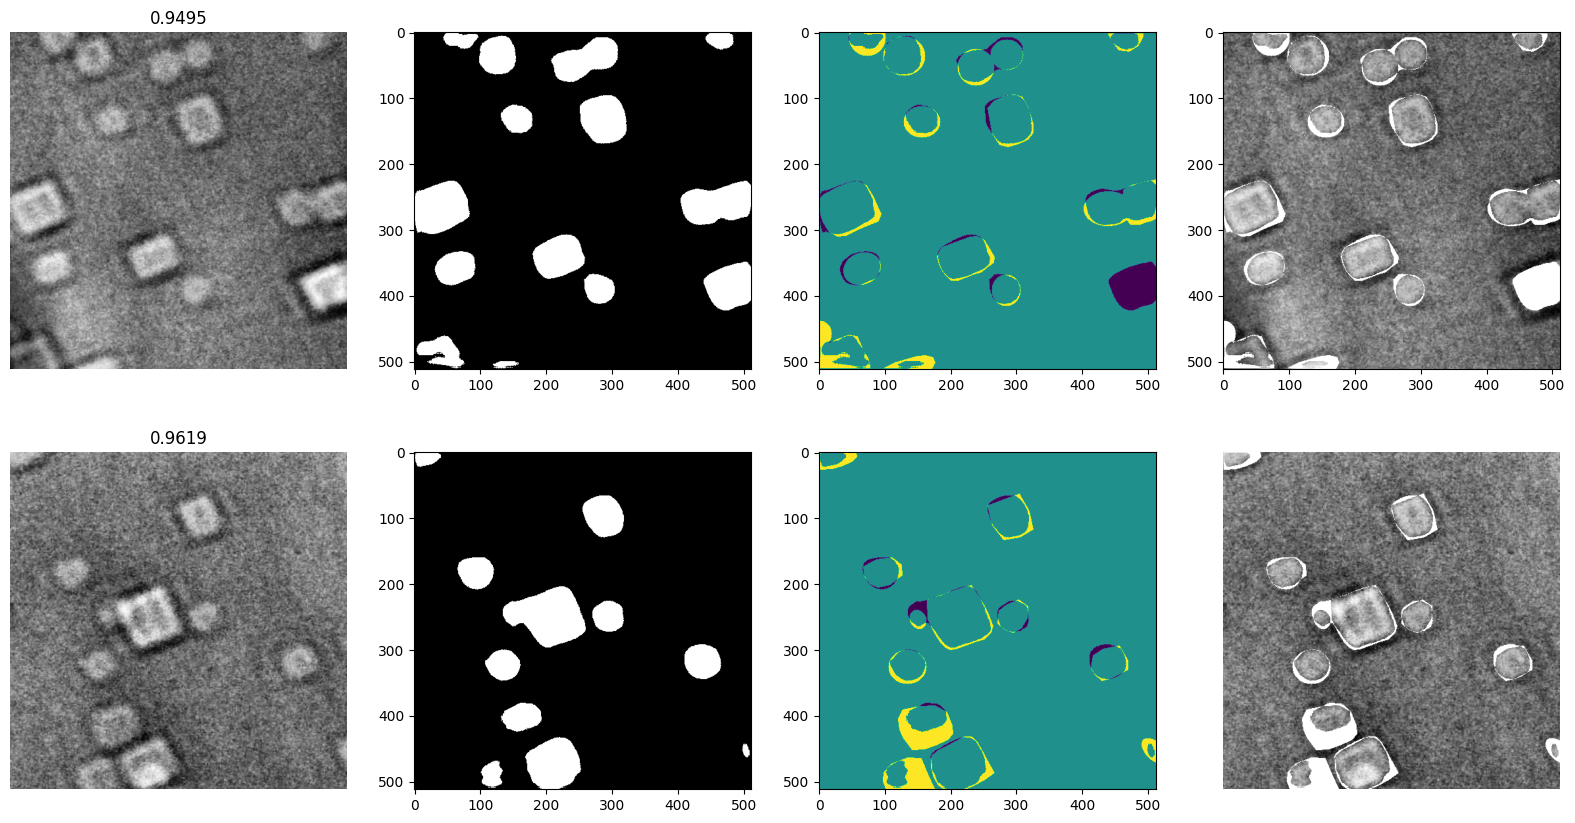

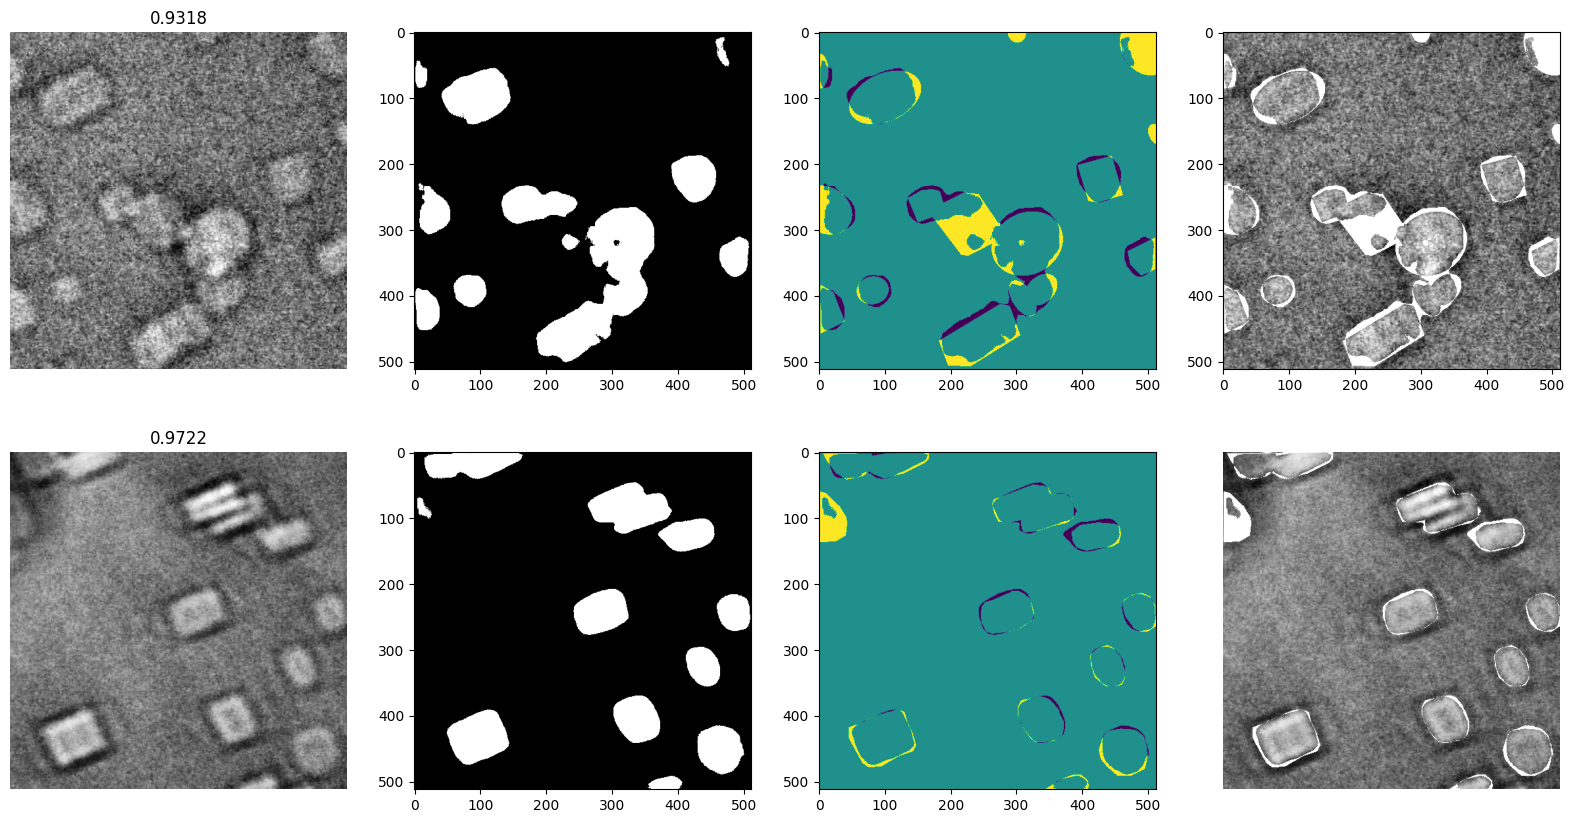

In [5]:

ds = datasets.create_test_dataset(batch=2)

def accuracy_ordering(images, masks, predictions):
  acc = [None]*images.shape[0]
  for i in range(images.shape[0]):
    prediction = predictions[i].reshape((512, 512))
    image = images[i].reshape((512, 512))
    mask = masks[i].reshape((512, 512))      
    p = (prediction >= 0.5)*1 
    mislabels = np.abs(mask - p)
    n = np.sum(mislabels == 1.)
    acc[i] = 1 - n/(512. * 512.)
  if True:
    return list(range(images.shape[0]))
  return np.array(acc).argsort()

def plot_predictions(images, masks, predictions):
  images = images.numpy()
  masks = masks.numpy()
  acc_order = accuracy_ordering(images, masks, predictions)
  images = images[acc_order]
  masks = masks[acc_order]
  predictions = predictions[acc_order]
  N = images.shape[0]
  n_cols = 4
  n_rows = N
  plt.rcParams["figure.figsize"] = (5*n_cols, 5*n_rows)
  f, a = plt.subplots(n_rows, n_cols)
  plt.axis('off')
  for i in range(N):
    plot_prediction(images[i], masks[i], predictions[i], a[i])

def plot_prediction(image, mask, prediction, ax):
  prediction = prediction.reshape((512, 512))
  image = image.reshape((512, 512))
  mask = mask.reshape((512, 512))
  p = (prediction >= 0.5)*1
  ax[0].axis('off')
  ax[0].imshow(image, cmap='gray')
  ax[1].imshow(p, cmap='gray')
  ax[2].imshow(mask - p)
  white = np.ones((512, 512))
  mislabels = np.abs(mask - p)
  ax[3].imshow(image, cmap='gray', alpha=( 1 - mislabels))
  n = np.sum(mislabels == 1.)
  acc = 1 - n/(512. * 512.)
  ax[0].title.set_text(str(np.round(acc, 4)))

for (x, y) in ds:
  yy = model.predict(x)
  plot_predictions(x, y, yy)


In [ ]:
ds = datasets.create_test_dataset(batch = 28)
images = None
masks = None
for image, mask in ds:
  images = image
  masks = mask

masks_pred = model.predict(images)

Loading images from /content/Void-Segmentation/dataset/test.
Loading 28 images for testing.


In [ ]:
x = M.all_feature_metrics(masks, masks_pred, thresholds = [0.5, 0.6, 0.7, 0.8, 0.9])
pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Threshold'])

Precision    Recall       IOU  Threshold
0   0.834646  0.781327  0.716216        0.5
1   0.800525  0.749386  0.667396        0.6
2   0.742782  0.695332  0.590814        0.7
3   0.540682  0.506143  0.370504        0.8
4   0.125984  0.117936  0.067227        0.9

In [ ]:
x = M.all_pixel_metrics(masks, masks_pred, np.arange(0.01, 0.98, 0.01))
pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Accuracy', 'Mean Absolute Area Error', 'Threshold'])

Precision    Recall       IOU  Accuracy  Mean Absolute Area Error  \
0    0.444556  0.994622  0.443583  0.779123                  1.316516   
1    0.513597  0.990003  0.511191  0.833336                  0.978911   
2    0.556822  0.985791  0.552784  0.860103                  0.809622   
3    0.587457  0.982538  0.581844  0.876556                  0.704713   
4    0.611264  0.979912  0.604170  0.888006                  0.630763   
..        ...       ...       ...       ...                       ...   
92   0.978718  0.572980  0.566498  0.928564                  0.414936   
93   0.981452  0.550336  0.545164  0.925155                  0.439601   
94   0.984048  0.523888  0.519894  0.921087                  0.467894   
95   0.985989  0.491695  0.488766  0.916049                  0.501701   
96   0.987333  0.449523  0.447529  0.909360                  0.545281   

    Threshold  
0        0.01  
1        0.02  
2        0.03  
3        0.04  
4        0.05  
..        ...  
92       0.93  
93       0.94  
94       0.95  
95       0.96  
96       0.97  

[97 rows x 6 columns]